# Reduce images of CTIO Data in May/June 2017
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : June 4th 2017

### This notebook does reduction of images from Master Bias and Master Dark.
-----------------------------------------

- the images should have been previously Overscanned and Trimmed
- Notice the images are saved in images_notebooks/notebook_name
- must execute the javascript below first

In [8]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [9]:
print theNotebook

ReduceAllImages


In [10]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os

In [11]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [12]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal

In [13]:
import bottleneck as bn  # numpy's masked median is slow...really slow (in version 1.8.1 and lower)
print 'bottleneck version',bn.__version__

bottleneck version 1.2.0


In [14]:
import photutils
from astropy.stats import sigma_clipped_stats
from photutils import daofind
from photutils import CircularAperture
from astropy.visualization import SqrtStretch
from astropy.visualization.mpl_normalize import ImageNormalize
#from photutils.background import Background2D
from photutils import Background2D, SigmaClip, MedianBackground

In [15]:
from IPython.display import Image, display

In [16]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [17]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [18]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

### Output directory for images generated in the notebook view (not true fits images)

In [19]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [20]:
ensure_dir(dir_top_images) # create that directory

### Output of reduced fits images

In [21]:
outputdir="reduced_fitsimages"
ensure_dir(outputdir)

## Bias and Flat

In [22]:
inputbiasfile="../../BiasAndFlats/olivier/FinalMasterBias_CTIO.fits"

In [23]:
inputflatfile="../../BiasAndFlats/olivier/FinalMasterFlat_CTIO_RG715.fits"

In [24]:
master_bias = ccdproc.CCDData.read(inputbiasfile,unit=u.adu)

In [25]:
master_flat = ccdproc.CCDData.read(inputflatfile,unit=u.adu)

In [26]:
imstats = lambda dat: (dat.min(), dat.max(), dat.mean(), dat.std())

## Location of corrected images
----------------------------------

In [27]:
rootpath_rawimage="../OverScanRemove/trim_images"
MIN_IMGNUMBER=135
MAX_IMGNUMBER=303
object_name='HD160617_HD185975_HD205905 June 10th'
SelectTagRe='^trim_20170610_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^trim_20170610_[0-9]+.fits$'
NBIMGPERLROW=4

In [28]:
#dirlist_all=os.listdir(rootpath_rawimage) 

In [29]:
#if '.DS_Store' in dirlist_all:
#    dirlist_all.remove('.DS_Store')
dirlist=[]
dirlist.append(rootpath_rawimage)
dirlist_all=np.array(dirlist)

In [30]:
print dirlist_all

['../OverScanRemove/trim_images']


In [31]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [32]:
def MakeFileList():
    """
    MakeFileList : Make The List of files to open
    =============
    
    - we select the files which are of interest.
    - In particular select the number range
    
    """
    count=0
    
    for dir in dirlist_all: # loop on directories, one per image   (if necessary)    
            dir_leaf= dir # build the name of leaf directory
            listfiles=os.listdir(dir_leaf) 
            for filename in listfiles:
                if re.search(SearchTagRe,filename):  #example of filename filter
                    str_index=re.findall(SelectTagRe,filename)
                    count=count+1
                    index=int(str_index[0])
                    if index >= MIN_IMGNUMBER and index <= MAX_IMGNUMBER: 
                        indexes_files.append(index)         
                        shortfilename=dir_leaf+'/'+filename
                        filelist_fitsimages.append(shortfilename)
                    
    return

In [33]:
MakeFileList()   # Make the list

In [34]:
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [35]:
print len(indexes_files)

169


In [36]:
print len(filelist_fitsimages)

169


In [37]:
print indexes_files

[135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152
 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170
 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188
 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206
 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224
 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242
 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260
 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278
 279 280 281 282 283 284 285 286 287 288 289 290 291 292 293 294 295 296
 297 298 299 300 301 302 303]


In [38]:
len(indexes_files)

169

In [39]:
filelist_fitsimages

array(['../OverScanRemove/trim_images/trim_20170610_135.fits',
       '../OverScanRemove/trim_images/trim_20170610_136.fits',
       '../OverScanRemove/trim_images/trim_20170610_137.fits',
       '../OverScanRemove/trim_images/trim_20170610_138.fits',
       '../OverScanRemove/trim_images/trim_20170610_139.fits',
       '../OverScanRemove/trim_images/trim_20170610_140.fits',
       '../OverScanRemove/trim_images/trim_20170610_141.fits',
       '../OverScanRemove/trim_images/trim_20170610_142.fits',
       '../OverScanRemove/trim_images/trim_20170610_143.fits',
       '../OverScanRemove/trim_images/trim_20170610_144.fits',
       '../OverScanRemove/trim_images/trim_20170610_145.fits',
       '../OverScanRemove/trim_images/trim_20170610_146.fits',
       '../OverScanRemove/trim_images/trim_20170610_147.fits',
       '../OverScanRemove/trim_images/trim_20170610_148.fits',
       '../OverScanRemove/trim_images/trim_20170610_149.fits',
       '../OverScanRemove/trim_images/trim_20170610_150

In [40]:
len(filelist_fitsimages)

169

In [41]:
#sorted_dates=np.argsort(filelist_fitsimages)

In [42]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [43]:
sorted_indexes

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168])

In [44]:
#print sorted_dates

In [45]:
print sorted_indexes

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168]


In [46]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [47]:
#sorted_numbers= [indexes_files[index] for index in sorted_indexes]
sorted_numbers=indexes_files[sorted_indexes]

In [48]:
sorted_numbers

array([135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147,
       148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160,
       161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173,
       174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185, 186,
       187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199,
       200, 201, 202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212,
       213, 214, 215, 216, 217, 218, 219, 220, 221, 222, 223, 224, 225,
       226, 227, 228, 229, 230, 231, 232, 233, 234, 235, 236, 237, 238,
       239, 240, 241, 242, 243, 244, 245, 246, 247, 248, 249, 250, 251,
       252, 253, 254, 255, 256, 257, 258, 259, 260, 261, 262, 263, 264,
       265, 266, 267, 268, 269, 270, 271, 272, 273, 274, 275, 276, 277,
       278, 279, 280, 281, 282, 283, 284, 285, 286, 287, 288, 289, 290,
       291, 292, 293, 294, 295, 296, 297, 298, 299, 300, 301, 302, 303])

In [49]:
sorted_files

array(['../OverScanRemove/trim_images/trim_20170610_135.fits',
       '../OverScanRemove/trim_images/trim_20170610_136.fits',
       '../OverScanRemove/trim_images/trim_20170610_137.fits',
       '../OverScanRemove/trim_images/trim_20170610_138.fits',
       '../OverScanRemove/trim_images/trim_20170610_139.fits',
       '../OverScanRemove/trim_images/trim_20170610_140.fits',
       '../OverScanRemove/trim_images/trim_20170610_141.fits',
       '../OverScanRemove/trim_images/trim_20170610_142.fits',
       '../OverScanRemove/trim_images/trim_20170610_143.fits',
       '../OverScanRemove/trim_images/trim_20170610_144.fits',
       '../OverScanRemove/trim_images/trim_20170610_145.fits',
       '../OverScanRemove/trim_images/trim_20170610_146.fits',
       '../OverScanRemove/trim_images/trim_20170610_147.fits',
       '../OverScanRemove/trim_images/trim_20170610_148.fits',
       '../OverScanRemove/trim_images/trim_20170610_149.fits',
       '../OverScanRemove/trim_images/trim_20170610_150

## Build full filename
----------------------------

In [50]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(rootpath_rawimage,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [51]:
sorted_filenames=np.array(sorted_filenames)

In [52]:
sorted_filenames

array(['../OverScanRemove/trim_images/trim_20170610_135.fits',
       '../OverScanRemove/trim_images/trim_20170610_136.fits',
       '../OverScanRemove/trim_images/trim_20170610_137.fits',
       '../OverScanRemove/trim_images/trim_20170610_138.fits',
       '../OverScanRemove/trim_images/trim_20170610_139.fits',
       '../OverScanRemove/trim_images/trim_20170610_140.fits',
       '../OverScanRemove/trim_images/trim_20170610_141.fits',
       '../OverScanRemove/trim_images/trim_20170610_142.fits',
       '../OverScanRemove/trim_images/trim_20170610_143.fits',
       '../OverScanRemove/trim_images/trim_20170610_144.fits',
       '../OverScanRemove/trim_images/trim_20170610_145.fits',
       '../OverScanRemove/trim_images/trim_20170610_146.fits',
       '../OverScanRemove/trim_images/trim_20170610_147.fits',
       '../OverScanRemove/trim_images/trim_20170610_148.fits',
       '../OverScanRemove/trim_images/trim_20170610_149.fits',
       '../OverScanRemove/trim_images/trim_20170610_150

## Acces to data of  images
----------------------------------

In [53]:
all_dates = []
all_airmass = []
all_images = []
all_titles = []
all_header = []
all_img = []
all_filt= []

In [54]:
def BuildRawImages():
    """
    BuildRawImages
    ===============
    """

    global all_dates
    global all_airmass
    global all_images
    global all_titles
    global all_header
    global all_img 
    global sorted_filenames
    global all_filt

    for idx,file in np.ndenumerate(sorted_filenames):   
        hdu_list=fits.open(file)
        header=hdu_list[0].header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        filters = header['FILTERS']
        num=sorted_numbers[idx[0]]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        image_corr=hdu_list[0].data
        image=image_corr
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        all_images.append(image)
        all_titles.append(title)
        all_header.append(header)
        all_filt.append(filters)
        hdu_list.close()      

In [55]:
BuildRawImages()

## Show images
-----------------------

In [56]:
def ShowRawImages():
    """
    ShowRawImages: Show the raw images without background subtraction
    ==============
    """
    #global all_images
    #global all_titles
    #global object_name

    
    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1

    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,130))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        #im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',norm=LogNorm(vmin=0.1, vmax=10))
        im=axarr[iy,ix].imshow(all_images[index],origin='lower',cmap='rainbow',vmin=0, vmax=1000)
        #axarr[iy,ix].annotate(all_filt[index], xy=(1000., 1500.),fontsize=16,color='yellow')
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='yellow', fontweight='bold',fontsize=16)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].grid(color='white', ls='solid')
    title='Raw images of {}'.format(object_name)
    plt.suptitle(title,size=16)  
    figfilename=os.path.join(dir_top_images,'viewrawimages.pdf')
    plt.savefig(figfilename)  

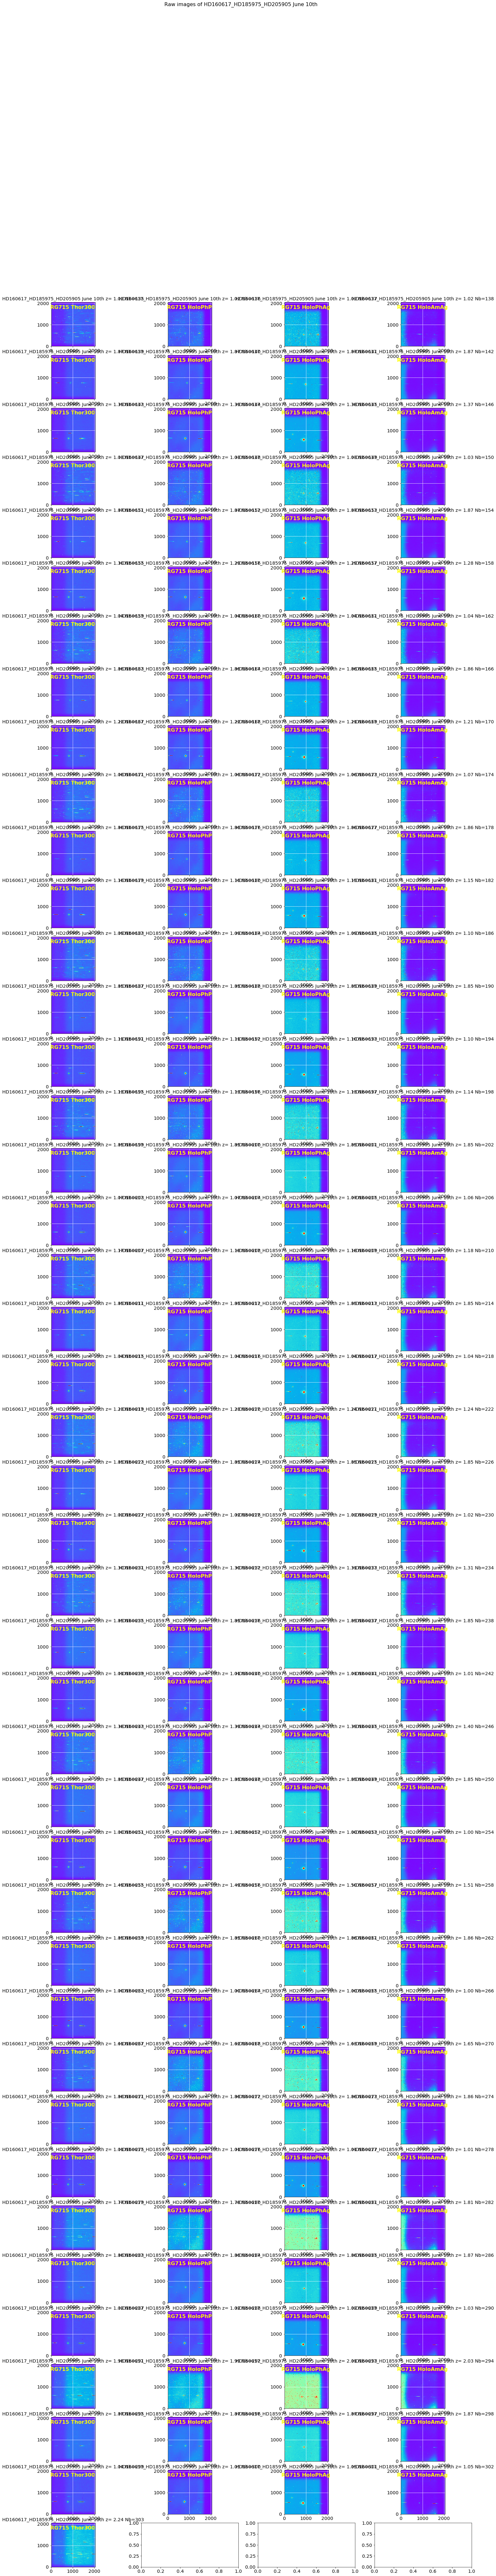

In [57]:
ShowRawImages()

In [58]:
#(y0,x0)=np.where(data2==data2.max())

The history saving thread hit an unexpected error (OperationalError('unable to open database file',)).History will not be written to the database.


## Show histograms
===========================

In [59]:
def ShowHistograms():
    """
    ShowHistograms
    ==============
    """
    global all_images
    global all_titles
    global object_name


    NBIMAGES=len(all_images)
    MAXIMGROW=int(NBIMAGES/NBIMGPERLROW)+1
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,150))
    for index in np.arange(0,NBIMAGES):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        image_flat=all_images[index].flatten()
        stat_mean=image_flat.mean()
        stat_rms=image_flat.std()
        legtitle='mean={:4.2f} std={:4.2f}'.format(stat_mean,stat_rms)
        axarr[iy,ix].hist(image_flat,bins=100,range=(-50,20000),facecolor='blue', alpha=0.75,label=legtitle);
        axarr[iy,ix].set_yscale('log')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,1e9)
        axarr[iy,ix].text(100.,1e6,all_filt[index],verticalalignment='bottom', horizontalalignment='left',color='red', fontweight='bold',fontsize=16)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].legend(loc='best')  #useless
    title='histo of images '.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'histosrawimages.pdf')
    plt.savefig(figfilename)    

In [60]:
ShowHistograms()

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/IPython/core/ultratb.py", line 1132, in get_records
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/IPython/core/ultratb.py", line 313, in wrapped
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/IPython/core/ultratb.py", line 358, in _fixed_getinnerframes
    records = fix_frame_records_filenames(inspect.getinnerframes(etb, context))
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/inspect.py", line 1049, in getinnerframes
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/inspect.py", line 1009, in getframeinfo
    filename = getsourcefile(frame) or getfile(frame)
  File "/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/inspect.py", line 454, in getsourcefile
    if hasattr(getmodule(object, filena

IndexError: string index out of range

IOError: [Errno 24] Too many open files: u'/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansDisplay.ttf'

## Transfer the image in CCDData
====================================

In [61]:
NBIMAGES=len(all_images)
all_rawimage = []
for index in np.arange(0,NBIMAGES):
    rawccd=ccdproc.CCDData(all_images[index],unit='adu')
    all_rawimage.append(rawccd)

## Does the reduction
===========================

### Step 1 : Subtract Bias to each raw image

In [62]:
all_bias_subtracted = []
for raw_image in all_rawimage:
    bias_subtracted = ccdproc.subtract_bias(raw_image, master_bias)
    all_bias_subtracted.append(bias_subtracted)

### Step 2 : Normalize by Flat

In [ ]:
all_reduced = []
for bias_sub in all_bias_subtracted:
    reduced_image = ccdproc.flat_correct(bias_sub, master_flat,min_value=0.5)
    all_reduced.append(reduced_image)

## Plot Reduced Image
=========================

In [ ]:
def PlotReduced():
    """
    PlotReduced
    ===============
    """
    
    global all_reduced
    global all_title
    global object_name
    
    NBBKG=len(all_reduced)
    MAXIMGROW=int(NBBKG/NBIMGPERLROW)+1
      
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,130))
    for index in np.arange(0,NBBKG):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        im=axarr[iy,ix].imshow(all_reduced[index],origin='lower',cmap='rainbow',vmin=0, vmax=1000)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].text(1000.,1700,all_filt[index],verticalalignment='bottom', horizontalalignment='center',color='red', fontweight='bold',fontsize=16)
    title='Reduced image {}'.format(object_name)

    #f.colorbar(im, ax=axarr.ravel().tolist(),shrink=0.75)
    f.colorbar(im)
    plt.suptitle(title,size=16) 
    figfilename=os.path.join(dir_top_images,'redimages.pdf')
    plt.savefig(figfilename)    

In [ ]:
PlotReduced()

In [ ]:
def PlotHistoReduced():
    """
    """
    
    global all_reduced
    global all_title
    global object_name
    
    NBIMG=len(all_reduced)
    MAXIMGROW=int(NBIMG/NBIMGPERLROW)+1
    
    f, axarr = plt.subplots(MAXIMGROW,NBIMGPERLROW,figsize=(25,130))
    for index in np.arange(0,NBIMG):
        ix=index%NBIMGPERLROW
        iy=index/NBIMGPERLROW
        image_flat=all_reduced[index].data.flatten()
        stat_mean=image_flat.mean()
        stat_rms=image_flat.std()
        legtitle='mean={:4.2f} std={:4.2f}'.format(stat_mean,stat_rms)
        axarr[iy,ix].hist(image_flat,bins=120,range=(-50,20000),facecolor='blue', alpha=0.75,label=legtitle);
        axarr[iy,ix].set_yscale('log')
        axarr[iy,ix].grid(True)
        axarr[iy,ix].set_ylim(0.,1e9)
        axarr[iy,ix].set_title(all_titles[index])
        axarr[iy,ix].legend(loc='best')  #useless
        axarr[iy,ix].text(100.,1e6,all_filt[index],verticalalignment='bottom', horizontalalignment='left',color='red', fontweight='bold',fontsize=16)
    title='histo of reduced images of {}'.format(object_name)
    plt.suptitle(title,size=16)
    figfilename=os.path.join(dir_top_images,'historedimages.pdf')
    plt.savefig(figfilename) 

In [ ]:
PlotHistoReduced()

## Save the reduced images
----------------------------------------------------------

### Generate the output filenames

In [ ]:
newfullfilenames=[]
for idx,file in np.ndenumerate(sorted_files):
    
    short_infilename=file.split("/")[3]
    short_partfilename=re.findall('^trim_(.*)',short_infilename)
    short_outfilename='reduc_'+short_partfilename[0]
    newfullfilename=os.path.join(outputdir,short_outfilename)
    newfullfilenames.append(newfullfilename)

In [ ]:
newfullfilenames

### Save output fits files

In [ ]:
for idx,file in np.ndenumerate(newfullfilenames):
    prihdu = fits.PrimaryHDU(header=all_header[idx[0]],data=all_reduced[idx[0]])
    thdulist = fits.HDUList(prihdu)
    thdulist.writeto(file,overwrite=True)